In [42]:
import joblib
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
import time
from tkinter import *
from tkinter import filedialog
from tqdm import tqdm
import itertools
import math

In [43]:
def adp_filt(currdf: object, pose):
    lIndex = []
    xIndex = []
    yIndex = []
    currdf = np.array(currdf[1:])
    for header in pose:
        if currdf[0][header + 1] == "likelihood":
            lIndex.append(header)
        elif currdf[0][header + 1] == "x":
            xIndex.append(header)
        elif currdf[0][header + 1] == "y":
            yIndex.append(header)
    curr_df1 = currdf[:, 1:]
    datax = curr_df1[1:, np.array(xIndex)]
    datay = curr_df1[1:, np.array(yIndex)]
    data_lh = curr_df1[1:, np.array(lIndex)]
    currdf_filt = np.zeros((datax.shape[0], (datax.shape[1]) * 2))
    perc_rect = []
    for i in range(data_lh.shape[1]):
        perc_rect.append(0)
    for x in tqdm(range(data_lh.shape[1])):
        a, b = np.histogram(data_lh[1:, x].astype(np.float))
        rise_a = np.where(np.diff(a) >= 0)
        if rise_a[0][0] > 1:
            llh = b[rise_a[0][0]]
        else:
            llh = b[rise_a[0][1]]
        # llh=0
        data_lh_float = data_lh[:, x].astype(np.float)
        perc_rect[x] = np.sum(data_lh_float < llh) / data_lh.shape[0]
        currdf_filt[0, (2 * x):(2 * x + 2)] = np.hstack([datax[0, x], datay[0, x]])
        for i in range(1, data_lh.shape[0]):
            if data_lh_float[i] < llh:
                currdf_filt[i, (2 * x):(2 * x + 2)] = currdf_filt[i - 1, (2 * x):(2 * x + 2)]
            else:
                currdf_filt[i, (2 * x):(2 * x + 2)] = np.hstack([datax[i, x], datay[i, x]])
    currdf_filt = np.array(currdf_filt)
    currdf_filt = currdf_filt.astype(np.float)
    return currdf_filt, perc_rect

def boxcar_center(a, n):
    a1 = pd.Series(a)
    moving_avg = np.array(a1.rolling(window=n, min_periods=1, center=True).mean())

    return moving_avg

In [44]:
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
infiles = filedialog.askopenfilename(multiple=True, title='load deeplabcut csv')

%gui tk

In [45]:
df = pd.read_csv(infiles[0], low_memory=False)

In [46]:
df

,scorer,DLC_resnet50_bottomup_clearSep21shuffle1_1030000,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.1,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.2,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.3,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.4,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.5,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.6,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.7,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.8,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.9,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.10,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.11,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.12,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.13,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.14,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.15,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.16,DLC_resnet50_bottomup_clearSep21shuffle1_1030000.17
0,bodyparts,snout,snout,snout,right-forepaw,right-forepaw,right-forepaw,left-forepaw,left-forepaw,left-forepaw,right-hindpaw,right-hindpaw,right-hindpaw,left-hindpaw,left-hindpaw,left-hindpaw,tail-base,tail-base,tail-base
1,coords,x,y,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood,x,y,likelihood
2,0,433.7218933105469,481.93359375,0.9994862079620361,398.1558837890625,488.0100402832031,0.9962955117225647,412.28070068359375,509.15435791015625,0.9994186162948608,364.80816650390625,521.5546264648438,0.9984946250915527,401.217041015625,533.2017211914062,0.9998083710670471,367.8746337890625,553.4801025390625,0.9995847344398499
3,1,438.2349853515625,485.09356689453125,0.9995527863502502,398.750732421875,488.8730773925781,0.9937505125999451,412.0513916015625,509.1146545410156,0.9992316961288452,365.515380859375,523.0096435546875,0.9987745881080627,400.0931701660156,533.0562133789062,0.9997743964195251,366.3837890625,554.027587890625,0.9995580315589905
4,2,440.2109680175781,490.8921813964844,0.9991874098777771,399.5596618652344,488.184326171875,0.9927864670753479,412.1019592285156,509.456298828125,0.998907208442688,365.57305908203125,523.4133911132812,0.9988771080970764,400.46173095703125,533.9353637695312,0.9997209906578064,365.8555603027344,553.937744140625,0.999545156955719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163012,163010,846.5376586914062,582.6831665039062,0.0012195650488138199,902.3479614257812,338.13232421875,4.539838482742198e-05,4.241046905517578,0.6390986442565918,3.0465716918115504e-05,501.151611328125,39.437591552734375,0.0034240898676216602,1.0022649765014648,-0.065673828125,1.928767960635014e-05,496.8975830078125,62.91470718383789,0.004334553144872189
163013,163011,847.4208984375,582.2416381835938,0.0005238725570961833,902.0457153320312,336.6177978515625,0.00017642724560573697,865.1449584960938,265.9806213378906,3.9765120163792744e-05,501.8307800292969,39.87351989746094,0.0007668870384804904,1.040207862854004,0.011960506439208984,2.178665999963414e-05,496.4051208496094,63.29104995727539,0.0026469281874597073
163014,163012,847.3697509765625,582.2019653320312,0.0004809517413377762,902.1434326171875,336.8197021484375,0.00021731905872002244,865.2023315429688,265.9165344238281,3.3894564694492146e-05,501.6358337402344,40.3604850769043,0.0016281604766845703,1.1250526905059814,0.4061286449432373,3.153323268634267e-05,496.4085998535156,62.95435333251953,0.0076792859472334385
163015,163013,847.9351196289062,583.5549926757812,0.0007726519834250212,902.3949584960938,337.73614501953125,7.058735354803503e-05,4.381392955780029,0.6859257221221924,2.679413228179328e-05,500.1901550292969,40.660884857177734,0.0048300037160515785,498.489013671875,42.8333740234375,2.133642374246847e-05,497.0765075683594,63.12519073486328,0.04391193389892578


In [5]:
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
infiles_clf = filedialog.askopenfilename(multiple=False, title='load classifier file .sav')

%gui tk

In [7]:
infiles_clf

'D:/DeepLabStream/Sep-07-2022_randomforest.sav'

In [8]:
with open(infiles_clf, 'rb') as fr:
    random_forest_sav = joblib.load(fr)

C:\Users\jimi\anaconda3\envs\closed-loop\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\jimi\anaconda3\envs\closed-loop\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
clf = random_forest_sav[3]
clf

RandomForestClassifier(max_features='auto', random_state=42)

In [10]:
csv_array_filtered, perc_filtered = adp_filt(df, np.arange(18))

  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\jimi\AppData\Local\Temp\ipykernel_19592\3076676940.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  a, b = np.histogram(data_lh[1:, x].astype(np.float))
C:\Users\jimi\AppData\Local\Temp\ipykernel_19592\3076676940.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://n

In [12]:
csv_array_filtered.shape

(125752, 12)

In [11]:
# csv_array.shape
processed_input_data = [csv_array_filtered.copy()]

In [13]:
framerate = 30
window = np.int(np.round(0.05 / (1 / framerate)) * 2 - 1)
f = []
for n in range(len(processed_input_data)):
    data_n_len = len(processed_input_data[n])
    dxy_list = []
    disp_list = []
    for r in range(data_n_len):
        if r < data_n_len - 1:
            disp = []
            for c in range(0, processed_input_data[n].shape[1], 2):
                disp.append(
                    np.linalg.norm(processed_input_data[n][r + 1, c:c + 2] -
                                   processed_input_data[n][r, c:c + 2]))
            disp_list.append(disp)
        dxy = []
        for i, j in itertools.combinations(range(0, processed_input_data[n].shape[1], 2), 2):
            dxy.append(processed_input_data[n][r, i:i + 2] -
                       processed_input_data[n][r, j:j + 2])
        dxy_list.append(dxy)
    disp_r = np.array(disp_list)
    dxy_r = np.array(dxy_list)
    disp_boxcar = []
    dxy_eu = np.zeros([data_n_len, dxy_r.shape[1]])
    ang = np.zeros([data_n_len - 1, dxy_r.shape[1]])
    dxy_boxcar = []
    ang_boxcar = []
    for l in range(disp_r.shape[1]):
        disp_boxcar.append(boxcar_center(disp_r[:, l], window))
        # disp_boxcar.append(disp_r[:, l])
    for k in range(dxy_r.shape[1]):
        for kk in range(data_n_len):
            dxy_eu[kk, k] = np.linalg.norm(dxy_r[kk, k, :])
            if kk < data_n_len - 1:
                b_3d = np.hstack([dxy_r[kk + 1, k, :], 0])
                a_3d = np.hstack([dxy_r[kk, k, :], 0])
                c = np.cross(b_3d, a_3d)
                ang[kk, k] = np.dot(np.dot(np.sign(c[2]), 180) / np.pi,
                                    math.atan2(np.linalg.norm(c),
                                               np.dot(dxy_r[kk, k, :], dxy_r[kk + 1, k, :])))
        dxy_boxcar.append(boxcar_center(dxy_eu[:, k], window))
        ang_boxcar.append(boxcar_center(ang[:, k], window))
        # dxy_boxcar.append(dxy_eu[:, k])
        # ang_boxcar.append(ang[:, k])
    disp_feat = np.array(disp_boxcar)
    dxy_feat = np.array(dxy_boxcar)
    ang_feat = np.array(ang_boxcar)
    f.append(np.vstack((dxy_feat[:, 1:], ang_feat, disp_feat)))

for m in range(0, len(f)):
    f_integrated = np.zeros(len(processed_input_data[m]))
    for k in range(round(framerate / 10), len(f[m][0]), round(framerate / 10)):
        if k > round(framerate / 10):
            f_integrated = np.concatenate(
                (f_integrated.reshape(f_integrated.shape[0], f_integrated.shape[1]),
                 np.hstack((np.mean((f[m][0:dxy_feat.shape[0],
                                     range(k - round(framerate / 10), k)]), axis=1),
                            np.sum((f[m][dxy_feat.shape[0]:f[m].shape[0],
                                    range(k - round(framerate / 10), k)]), axis=1)
                            )).reshape(len(f[0]), 1)), axis=1
            )
        else:
            f_integrated = np.hstack(
                (np.mean((f[m][0:dxy_feat.shape[0], range(k - round(framerate / 10), k)]), axis=1),
                 np.sum((f[m][dxy_feat.shape[0]:f[m].shape[0],
                         range(k - round(framerate / 10), k)]), axis=1))).reshape(len(f[0]), 1)
    if m > 0:
        features = np.concatenate((features, f_integrated), axis=1)
    else:
        features = f_integrated

C:\Users\jimi\AppData\Local\Temp\ipykernel_19592\1596035890.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  window = np.int(np.round(0.05 / (1 / framerate)) * 2 - 1)


In [15]:
f_integrated.T.shape

(41916, 36)

In [14]:
X = features.T.copy()
predictions = clf.predict(X)

Text(0.5, 0, 'time (s)')

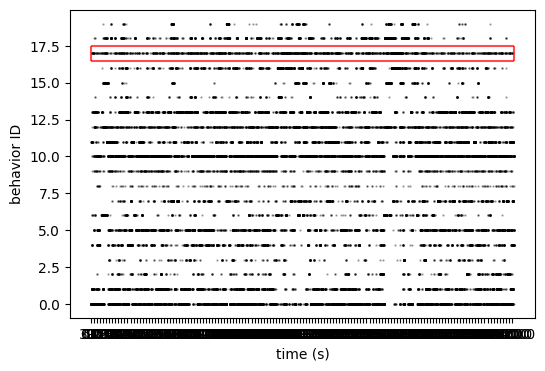

In [16]:
class_of_interest=17
jitter=0.5
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hlines(class_of_interest-jitter, 0, len(predictions), 'r', alpha=0.7)
ax.hlines(class_of_interest+jitter, 0, len(predictions), 'r', alpha=0.7)
ax.vlines(0-jitter, class_of_interest-jitter, class_of_interest+jitter, 'r', alpha=0.7)
ax.vlines(len(predictions)+jitter, class_of_interest-jitter, class_of_interest+jitter, 'r', alpha=0.7)
ax.scatter(np.arange(len(predictions)), predictions, s=0.5, color='k', alpha=0.3)
ax.set_xticks(np.arange(0, len(predictions), 300))
ax.set_xticklabels(np.arange(0, len(predictions)/10, 30))
ax.set_ylabel('behavior ID')
ax.set_xlabel('time (s)')
# fig.savefig('./test.png', dpi=600)

## Split session into multiple 10 minute predictions

In [40]:
# 10 minutes (600 seconds, or 6000 * 100ms predictions)
bin_time = 10
time_bin = bin_time*60*10 
# print(round(len(predictions)/time_bin))
pred_split = []
for bin_num in range(int(len(predictions)/time_bin)+1):
    # print((bin_num)*time_bin, (bin_num+1)*time_bin)
    
    pred_split.append(predictions[(bin_num)*time_bin:(bin_num+1)*time_bin])
print(pred_split)


[array([ 0, 11, 11, ...,  0,  0,  0], dtype=int64), array([ 0,  0, 13, ...,  5,  5,  5], dtype=int64), array([ 5,  5,  5, ...,  5, 12,  4], dtype=int64), array([10,  1,  1, ..., 12, 12, 12], dtype=int64), array([11, 11, 11, ..., 18, 18, 18], dtype=int64), array([18, 18, 18, ...,  5,  5,  5], dtype=int64), array([ 5,  5,  5, ..., 10, 10, 10], dtype=int64)]


In [39]:
infiles[0].rpartition('DLC')[0]

'D:/Jack/Project/P16/091222/VideoOutputCamera 0-12092022-133159'

In [41]:
for i in range(len(pred_split)):
    fileoutname = str.join('', (infiles[0].rpartition('DLC')[0], f'_posthoc-predictions_{bin_time}min_seg{i}.npy'))
    np.save(fileoutname, pred_split[i])
    print(fileoutname)

D:/Jack/Project/P16/091222/VideoOutputCamera 0-12092022-133159_posthoc-predictions_10min_seg0.npy
D:/Jack/Project/P16/091222/VideoOutputCamera 0-12092022-133159_posthoc-predictions_10min_seg1.npy
D:/Jack/Project/P16/091222/VideoOutputCamera 0-12092022-133159_posthoc-predictions_10min_seg2.npy
D:/Jack/Project/P16/091222/VideoOutputCamera 0-12092022-133159_posthoc-predictions_10min_seg3.npy
D:/Jack/Project/P16/091222/VideoOutputCamera 0-12092022-133159_posthoc-predictions_10min_seg4.npy
D:/Jack/Project/P16/091222/VideoOutputCamera 0-12092022-133159_posthoc-predictions_10min_seg5.npy
D:/Jack/Project/P16/091222/VideoOutputCamera 0-12092022-133159_posthoc-predictions_10min_seg6.npy


In [21]:
fileoutname = str.join('', (infiles[0].rpartition('DLC')[0], '_posthoc-predictions.npy'))
np.save(fileoutname, predictions)

## put the below code in another notebook 
#### loop through all .npy files once analyzed

In [22]:
all_predictions = []
for _ in range(6):
    # join duplicates of the same array
    predictions = np.load(fileoutname)
    all_predictions.append(predictions)
# all_predictions
all_predictions_arr = np.hstack(all_predictions)

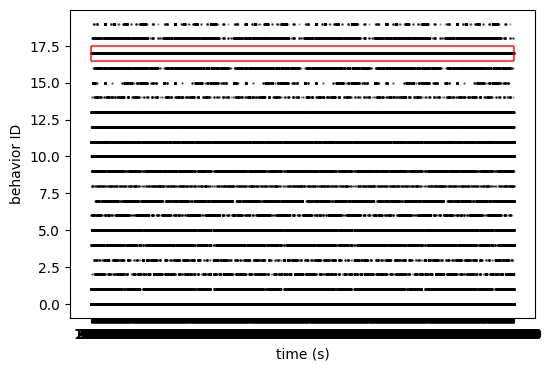

In [23]:
class_of_interest=17
jitter=0.5
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hlines(class_of_interest-jitter, 0, len(all_predictions_arr), 'r', alpha=0.7)
ax.hlines(class_of_interest+jitter, 0, len(all_predictions_arr), 'r', alpha=0.7)
ax.vlines(0-jitter, class_of_interest-jitter, class_of_interest+jitter, 'r', alpha=0.7)
ax.vlines(len(all_predictions_arr)+jitter, class_of_interest-jitter, class_of_interest+jitter, 'r', alpha=0.7)
ax.scatter(np.arange(len(all_predictions_arr)), all_predictions_arr, s=0.5, color='k', alpha=0.3)
ax.set_xticks(np.arange(0, len(all_predictions_arr), 300))
ax.set_xticklabels(np.arange(0, len(all_predictions_arr)/10, 30))
ax.set_ylabel('behavior ID')
ax.set_xlabel('time (s)')
fig.savefig('./test.png', dpi=600)

In [24]:
all_predictions_arr.shape

(251496,)

In [25]:
bin_start = np.arange(0, np.max(len(all_predictions_arr)), 600)
bin_end = np.arange(600, np.max(len(all_predictions_arr))+600, 600)
print(bin_start, bin_end)
binned_predictions = []
for b in range(len(bin_start)):
    binned_predictions.append(all_predictions_arr[bin_start[b]:bin_end[b]])


[     0    600   1200   1800   2400   3000   3600   4200   4800   5400
   6000   6600   7200   7800   8400   9000   9600  10200  10800  11400
  12000  12600  13200  13800  14400  15000  15600  16200  16800  17400
  18000  18600  19200  19800  20400  21000  21600  22200  22800  23400
  24000  24600  25200  25800  26400  27000  27600  28200  28800  29400
  30000  30600  31200  31800  32400  33000  33600  34200  34800  35400
  36000  36600  37200  37800  38400  39000  39600  40200  40800  41400
  42000  42600  43200  43800  44400  45000  45600  46200  46800  47400
  48000  48600  49200  49800  50400  51000  51600  52200  52800  53400
  54000  54600  55200  55800  56400  57000  57600  58200  58800  59400
  60000  60600  61200  61800  62400  63000  63600  64200  64800  65400
  66000  66600  67200  67800  68400  69000  69600  70200  70800  71400
  72000  72600  73200  73800  74400  75000  75600  76200  76800  77400
  78000  78600  79200  79800  80400  81000  81600  82200  82800  83400
  8400

<BarContainer object of 420 artists>

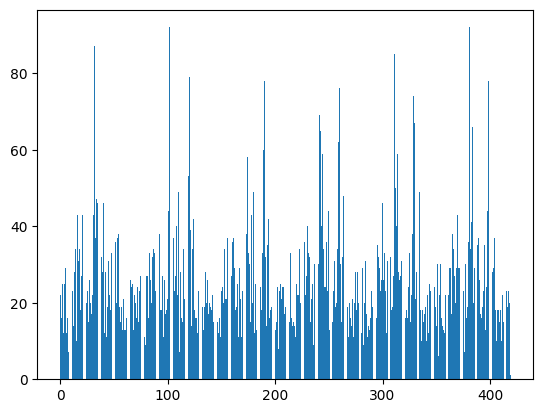

In [26]:
class_interest_binned = [len(np.where(binned_predictions[b] == class_of_interest)[0]) for b in range(len(binned_predictions))]

plt.bar(np.arange(len(class_interest_binned)), class_interest_binned)

In [27]:
np.arange(0, len(predictions), 300), np.arange(0, len(predictions)/10, 30)

(array([    0,   300,   600,   900,  1200,  1500,  1800,  2100,  2400,
         2700,  3000,  3300,  3600,  3900,  4200,  4500,  4800,  5100,
         5400,  5700,  6000,  6300,  6600,  6900,  7200,  7500,  7800,
         8100,  8400,  8700,  9000,  9300,  9600,  9900, 10200, 10500,
        10800, 11100, 11400, 11700, 12000, 12300, 12600, 12900, 13200,
        13500, 13800, 14100, 14400, 14700, 15000, 15300, 15600, 15900,
        16200, 16500, 16800, 17100, 17400, 17700, 18000, 18300, 18600,
        18900, 19200, 19500, 19800, 20100, 20400, 20700, 21000, 21300,
        21600, 21900, 22200, 22500, 22800, 23100, 23400, 23700, 24000,
        24300, 24600, 24900, 25200, 25500, 25800, 26100, 26400, 26700,
        27000, 27300, 27600, 27900, 28200, 28500, 28800, 29100, 29400,
        29700, 30000, 30300, 30600, 30900, 31200, 31500, 31800, 32100,
        32400, 32700, 33000, 33300, 33600, 33900, 34200, 34500, 34800,
        35100, 35400, 35700, 36000, 36300, 36600, 36900, 37200, 37500,
      